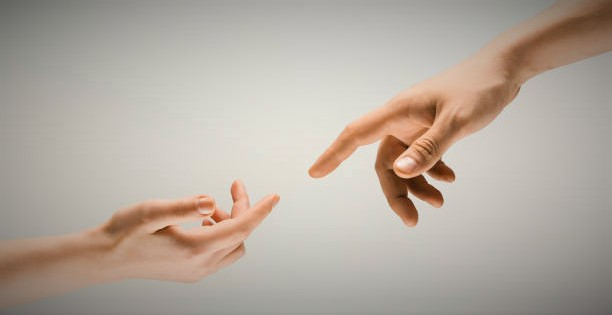

This data comes from an experiment conducted at Ariel University by Dr. Roi Yozevitch. The study sought to test whether it is possible through ML to know whether a pair of hands are in a synchronous, spontaneous state or alone.

Tasks to perform:
1. Load data of each condition per subject in the experiment (total 3 per person).
2. Merge right hand and left hand in each frame.
3. Merge 5 frames into a vector.
4. Train a model and choose a final model for the test.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.patches as patches
from matplotlib.patches import Rectangle, PathPatch
import mpl_toolkits.mplot3d.art3d as art3d
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
from sklearn.utils import shuffle
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier,ExtraTreesClassifier,VotingClassifier,BaggingClassifier,StackingClassifier,AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split,GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.decomposition import PCA
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix,accuracy_score,f1_score,precision_score,recall_score
from sklearn.metrics import precision_recall_fscore_support as score
from xgboost import XGBClassifier
import glob
import os
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline

Here is an example of one of the files:

In [2]:
data = pd.read_csv(r'C:\Users\נעמיה\data-science\extraFiles\Training\Evyatar Cohen\Evyatar636771052727603804Spontan.csv')
data.head(10)

,Time,Frame ID,Hand Type,# hands,Position X,Position Y,Position Z,Velocity X,Velocity Y,Velocity Z,...,Yaw,Wrist Pos X,Wrist Pos Y,Wrist Pos Z,Elbow pos X,Elbow Pos Y,Elbow Pos Z,Grab Strenth,Grab Angle,Pinch Strength
0,335.9984,128556,right,2,128.63570,224.0294,-12.29588,-18.26243,-140.54450,-117.577900,...,-1.588251,177.5125,173.5658,-14.569630,276.8753,-33.68264,91.61740,0.0,1.250576,0.0
1,335.9984,128556,left,2,-93.24845,143.9423,-37.81597,-109.09820,240.38980,-67.629590,...,0.873458,-147.0455,109.9380,-5.326688,-329.8577,-34.41571,93.88171,0.0,0.014736,0.0
2,336.0150,128558,right,2,129.15550,221.9923,-15.00181,47.36464,-64.25022,-168.858500,...,-1.528183,177.7894,171.1952,-14.677850,276.0645,-33.15913,97.88171,0.0,1.069930,0.0
3,336.0150,128558,left,2,-94.86554,148.5542,-39.00158,-80.99012,278.60220,-66.793560,...,0.879703,-148.2022,113.0909,-7.375025,-326.9279,-39.97873,85.98000,0.0,0.000000,0.0
4,336.0315,128560,right,2,129.87070,220.7944,-18.38681,35.05422,-84.74242,-205.720300,...,-1.461710,178.3730,169.9159,-15.246240,276.1767,-30.72506,104.13920,0.0,0.916969,0.0
5,336.0315,128560,left,2,-95.16259,152.5339,-39.94570,-11.37293,232.80310,-53.320790,...,0.895820,-148.3343,115.9295,-9.437292,-322.0559,-44.42383,81.02193,0.0,0.000000,0.0
6,336.0481,128562,right,2,131.07210,219.2134,-22.05511,36.51635,-153.35370,-212.825900,...,-1.380241,179.5035,168.4482,-15.568560,276.6018,-31.22840,105.96400,0.0,0.798334,0.0
7,336.0481,128562,left,2,-95.37997,156.0973,-40.18840,-3.05615,203.81210,19.494730,...,0.918827,-148.3562,118.3093,-10.919770,-314.2976,-49.04110,81.41824,0.0,0.000000,0.0
8,336.0651,128564,right,2,132.46290,216.8003,-25.45043,98.73232,-65.53646,-218.720100,...,-1.287442,179.5375,165.1393,-15.531890,271.5673,-37.88867,104.38140,0.0,0.728858,0.0
9,336.0651,128564,left,2,-97.10074,161.7751,-40.36338,-98.92747,316.64520,-7.328697,...,0.946004,-149.2292,121.7602,-12.780660,-299.9106,-56.55378,85.03669,0.0,0.000000,0.0


### Load and clean

These functions load the data and clean it according to the instructions:
Deleting the first seven seconds.
In the case of "Spontan" and "Sync" perform a union between the right frame and the left frame

In [3]:
Alone=0
Spontan=1
Sync=2

dictionary = {
    0 :'Alone',
    1 : 'Spontan',
    2 : 'Sync'
}
class_names = list(dictionary.values())

def LoadData(path):
        #create list for each state:
        AloneList=[];SpontanList=[];SyncList=[]
        all_files = glob.glob(path + "/*")
        for folder in all_files:
            print("\nloading in" ,os.path.basename(folder), ':')
            files = glob.glob(folder + "/*.csv")
            #find the 3 last files in each folder
            files=last3(files)
            for filename in files:
                df = pd.read_csv(filename, index_col=None, header=0)
                type = None
                
                if("Alone" in filename):
                    type = Alone
                    df=transform(df,type)
                    AloneList.append(df)
                elif("Sync" in filename):
                    type = Sync
                    df=transform(df,type)
                    SyncList.append(df)
                elif("Spontan" in filename):
                    type = Spontan
                    df=transform(df,type)
                    SpontanList.append(df)
                   
                print(os.path.basename(filename), type)
        listData = np.array([AloneList,SpontanList,SyncList])
        return listData

#If there are more than 3 files in the folder, this function takes the last three.
def last3(files):
    lafile=[]
    for i in range(3):
        latest_file = max(files, key=os.path.getmtime)
        lafile.append(latest_file)
        files.remove(latest_file)
    return lafile

def transform(df,type):
    #first, remove rows with NaN value.
    df=df.dropna().reset_index(drop=True)
    # restart the seconds in 'Time' column
    df.iloc[:,0] = df.iloc[:,0] - df.iloc[:,0][0]
    # remove 7 first seconds.
    df = remove7(df)
    df.columns = [c.replace(' ', '').replace('#', '') for c in df.columns]
    
    if type==0:# if this Alone data:
        df = df[df.iloc[:,3] == 1]
        return df
    #clean all values that the camera did not capture both hands in the same frame
    df = df[df.iloc[:,3] != 1]
    #now the 'hands' column is not needed so remove it
    df = df.drop(columns=df.columns[3])
    #split the data to right and left
    df_right=df[df.iloc[:, 2]=='right'].reset_index(drop=True)
    df_left=df[df.iloc[:, 2]=='left'].reset_index(drop=True)
    
    #After merging left and right columns, the "HandType" column is not needed.
    df_right = df_right.drop(columns=df_right.columns[2])
    df_left = df_left.drop(columns=df_left.columns[2])
    df=pd.merge(df_right, df_left, left_index=True, right_index=True)
    df.columns=[c.replace('_x', 'Right').replace('_y', 'Left') for c in df.columns]
    return df

    # this function remove 7 first second from the Data
def remove7(df):
    return df[df.iloc[:,0]>7].reset_index(drop=True)

In [4]:
pathTrain=r'C:\Users\נעמיה\data-science\extraFiles\Training'
pathTest=r'C:\Users\נעמיה\data-science\extraFiles\Validation'
print('Load the train data:')
listTrain=LoadData(pathTrain)
print('\nLoad the test data:')
listTest=LoadData(pathTest)

Load the train data:

loading in Evyatar Cohen :
Evyatar636771054555711409Alone.csv 0
Evyatar636771053639929594Sync.csv 2
Evyatar636771052727603804Spontan.csv 1

loading in Nofar Social_Nuero :
Nofar636759797397919664Sync.csv 2
Nofar636759796290435160Alone.csv 0
Nofar636759795182793299Spontan.csv 1

loading in Oriya Social_Nuero :
Oriya636759806131350399Sync.csv 2
Oriya636759805268396661Alone.csv 0
Oriya636759804404113837Spontan.csv 1

loading in Orya Kalmanovitz :
OryaB636771084494502229Sync.csv 2
OryaB636771083605535985Spontan.csv 1
OryaB636771082736601528Alone.csv 0

loading in Revital Marbel :
Revital636770957894370062Sync.csv 2
Revital636770957038873193Spontan.csv 1
Revital636770955999435879Alone.csv 0

loading in Shahar Terner :
Sachar636771047408504303Alone.csv 0
Sachar636771046527112972Sync.csv 2
Sachar636771045591258071Spontan.csv 1

loading in Shelly Social_Nuero :
Shelly636759789526313406Sync.csv 2
Shelly636759788383205274Alone.csv 0
Shelly636759787508979097Spontan.csv 1

lo

In [5]:
print(listTrain.shape)
print(listTest.shape)

(3, 9)
(3, 3)


In [6]:
listTrain[1][1].head()

,TimeRight,FrameIDRight,PositionXRight,PositionYRight,PositionZRight,VelocityXRight,VelocityYRight,VelocityZRight,PitchRight,RollRight,...,YawLeft,WristPosXLeft,WristPosYLeft,WristPosZLeft,ElbowposXLeft,ElbowPosYLeft,ElbowPosZLeft,GrabStrenthLeft,GrabAngleLeft,PinchStrengthLeft
0,7.0078,46229,178.0068,284.5815,117.9935,-108.98820,-110.82870,114.20760,1.670153,-1.198164,...,2.266312,-200.6938,283.2395,-8.000342,-364.8326,98.94038,-56.17548,0.0,0.636534,0.0
1,7.0243,46231,175.7417,281.9110,119.6351,-142.06860,-153.53760,96.67265,1.693667,-1.193420,...,2.280412,-201.2155,284.0092,-5.443998,-368.3081,104.15600,-59.86306,0.0,0.692922,0.0
2,7.0408,46233,173.9622,280.1721,121.5467,-78.12815,-72.85332,134.25710,1.717770,-1.192833,...,2.291920,-201.2202,283.6421,-2.860333,-367.2709,105.11800,-64.38165,0.0,0.763454,0.0
3,7.0574,46235,171.1448,277.2473,123.3778,-176.70390,-194.91130,102.17850,1.743827,-1.182313,...,2.295752,-201.3646,282.9786,-0.163662,-367.1341,106.23170,-67.34797,0.0,0.818487,0.0
4,7.0740,46237,168.0224,274.5504,125.2822,-220.48440,-179.12720,97.41615,1.768095,-1.165285,...,2.303698,-200.7781,280.8198,2.517915,-368.5150,107.43870,-68.53429,0.0,0.866876,0.0


Now load the AloneRight file to be merged with the Alone files

In [7]:
AloneRight = pd.read_csv(r'C:\Users\נעמיה\data-science\extraFiles\HandRight.csv')
AloneRight.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4812 entries, 0 to 4811
Data columns (total 22 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Time             4812 non-null   float64
 1    Frame ID        4812 non-null   int64  
 2    Hand Type       4812 non-null   object 
 3    # hands         4812 non-null   int64  
 4    Position X      4812 non-null   float64
 5    Position Y      4812 non-null   float64
 6    Position Z      4812 non-null   float64
 7    Velocity X      4812 non-null   float64
 8    Velocity Y      4812 non-null   float64
 9    Velocity Z      4812 non-null   float64
 10   Pitch           4812 non-null   float64
 11   Roll            4812 non-null   float64
 12   Yaw             4812 non-null   float64
 13   Wrist Pos X     4428 non-null   float64
 14   Wrist Pos Y     4428 non-null   float64
 15   Wrist Pos Z     4428 non-null   float64
 16   Elbow pos X     4428 non-null   float64
 17   Elbow Pos Y  

It can be seen that there are NaN values here.

In [8]:
#clean the data
AloneRight = transform(AloneRight,0) 

#replace 'left' at 'right'
for index, row in AloneRight.iterrows():
    AloneRight.loc[index,'HandType']='right'
    
#if there are duplicate rows - delete them
AloneRight=AloneRight.drop_duplicates().reset_index(drop=True)

Merge Alone data with AloneRight

In [9]:
def mergeAlone(listdata):
    for i in range(len(listdata)):
        temp=AloneRight
        
        #If AloneLeft has more rows than AloneRight, double AloneRight
        if len(listdata[i])>len(AloneRight):
            temp=pd.concat([AloneRight,AloneRight]).reset_index(drop=True)
            
        # find the spare rows in AloneRight:
        spare = len(temp)-len(listdata[i])
        temp = temp.drop(temp.tail(spare).index)
        
        temp = temp.drop(columns=temp.columns[[2,3]])
        listdata[i] = listdata[i].drop(columns=listdata[i].columns[[2,3]])
        
        df=pd.merge(temp, listdata[i], left_index=True, right_index=True)
        df.columns = [c.replace('_x', 'Right').replace('_y', 'Left') for c in df.columns]
        listdata[i] = df.reset_index(drop=True)
    return listdata

In [10]:
listTrain[Alone]=mergeAlone(listTrain[Alone])
listTest[Alone]=mergeAlone(listTest[Alone])

In [11]:
listTrain[Alone][1].head()

,TimeRight,FrameIDRight,PositionXRight,PositionYRight,PositionZRight,VelocityXRight,VelocityYRight,VelocityZRight,PitchRight,RollRight,...,YawLeft,WristPosXLeft,WristPosYLeft,WristPosZLeft,ElbowposXLeft,ElbowPosYLeft,ElbowPosZLeft,GrabStrenthLeft,GrabAngleLeft,PinchStrengthLeft
0,7.0141,16287,11.93032,199.9861,4.981665,-35.512210,-165.3466,-57.68153,-0.092033,0.108262,...,1.740217,-88.67735,226.0782,26.63538,-305.1488,102.22980,-36.521190,0.0,1.694959,0.221438
1,7.0311,16289,11.19190,195.3075,3.661716,-43.587440,-309.8374,-77.18515,-0.111674,0.126925,...,1.764604,-83.18510,215.6640,23.81408,-303.0901,93.46584,-30.005300,0.0,1.614523,0.118337
2,7.0474,16291,10.53308,189.0297,2.829388,-30.403600,-363.0033,-43.79815,-0.140004,0.127219,...,1.762232,-80.50581,208.0244,21.72965,-302.6205,85.71638,-21.777700,0.0,0.788199,0.010345
3,7.0641,16293,10.24300,181.9816,2.064330,-15.424000,-423.2120,-43.99948,-0.166623,0.122782,...,1.756342,-78.55511,201.2166,20.10092,-302.9675,79.83047,-12.938220,0.0,0.820752,0.000000
4,7.0807,16295,10.02061,174.8592,1.228467,-8.733602,-413.4513,-53.88054,-0.197763,0.127587,...,1.748369,-77.45807,194.3602,18.38106,-304.3510,75.53379,-5.846048,0.0,0.980538,0.000000


We will now illustrate the difference between the different modes -Alone, Spontan and Sync:

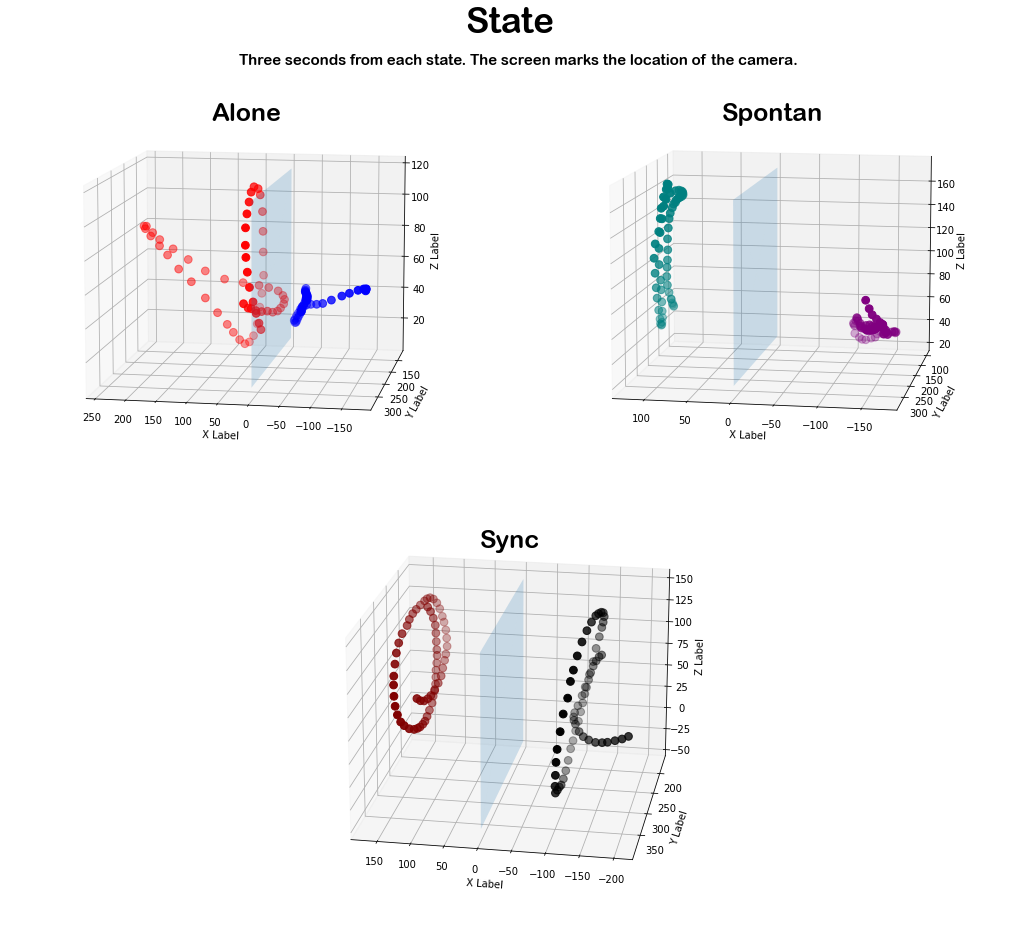

In [12]:
aa1=listTrain[0][1].query('30<=TimeRight<=32').iloc[::2,]
aa2=listTrain[1][1].query('30<=TimeRight<=32').iloc[::2,]
aa3=listTrain[2][1].query('30<=TimeRight<=32').iloc[::2,]

def Max(sr1,sr2):
    return max(max(sr1),max(sr2))
def Min(sr1,sr2):
    return min(min(sr1),min(sr2))

def scatterplot(df,c1,c2,title,elev,azim):
    ax.scatter(df['PositionXRight'], df['PositionYRight'], df['PositionZRight'], c=c1, marker='o',s=60)
    ax.scatter(df['PositionXLeft'], df['PositionYLeft'], df['PositionZLeft'], c=c2, marker='o',s=60)
    ax.set_xlabel('X Label')
    ax.set_ylabel('Y Label')
    ax.set_zlabel('Z Label')
    
    ymin=Min(df['PositionYLeft'],df['PositionYRight'])
    zmin=Min(df['PositionZLeft'],df['PositionZRight'])
    ymax=Max(df['PositionYLeft'],df['PositionYRight'])
    zmax=Max(df['PositionZLeft'],df['PositionZRight'])
    x = [0, 0, 0, 0]
    y = [ymin, ymin, ymax, ymax]
    z = [zmin, zmax, zmin, zmax]
    vertices = [[0, 1, 2], [0, 1, 3], [0, 2, 3], [1, 2, 3]]
    tupleList = list(zip(x, y, z))
    poly3d = [[tupleList[vertices[ix][iy]] for iy in range(len(vertices[0]))] for ix in range(len(vertices))]
    collection = Poly3DCollection(poly3d, linewidths=1, alpha=0.1)
    ax.add_collection3d(collection)
    ax.set_title(title,fontsize = 25, fontweight='light',fontfamily=font, y=0.93)
    ax.view_init(elev,azim)
font='Arial Rounded MT Bold'
fig = plt.figure(3,figsize=(18,25),)
plt.text(x=0.231,y=1,s='Three seconds from each state. The screen marks the location of the camera.',fontfamily=font,fontsize = 15)
plt.title('State',fontsize = 35, fontweight='bold',fontfamily=font, y=1.03)
plt.axis('off')
ax = fig.add_subplot(221, projection='3d')
scatterplot(aa1,'r','b','Alone',10,100)
ax = fig.add_subplot(222, projection='3d')
scatterplot(aa2,'teal','purple','Spontan',10,100)
ax = fig.add_subplot(212, projection='3d')
scatterplot(aa3,'maroon','black','Sync',20,100)
plt.subplots_adjust(wspace=0.1,top=0.6,hspace=0.001)


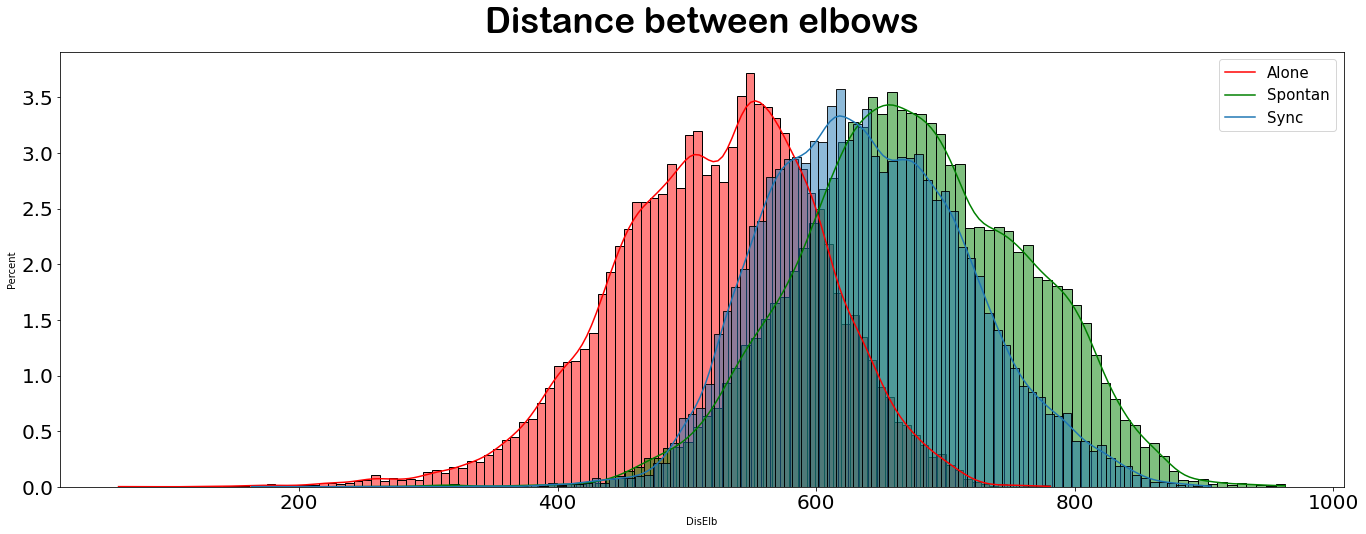

In [13]:
def DisVec(df):
    elb=[]
    for i in range(len(df)):
        vec1=np.array((df['ElbowposXLeft'][i],df['ElbowPosYLeft'][i],df['ElbowPosZLeft'][i]))
        vec2=np.array((df['ElbowposXRight'][i],df['ElbowPosYRight'][i],df['ElbowPosZRight'][i]))
        dist1 = np.linalg.norm(vec1-vec2)
        elb.append(dist1)
    df['DisElb']=pd.Series(elb)
    return df

al=pd.concat(listTrain[Alone].copy()).reset_index(drop=True)
sp=pd.concat(listTrain[Spontan].copy()).reset_index(drop=True)
sy=pd.concat(listTrain[Sync].copy()).reset_index(drop=True)
al=DisVec(al)
sp=DisVec(sp)
sy=DisVec(sy)
fig, ax = plt.subplots(figsize = (23,8))
plt.title('Distance between elbows',fontsize = 35, fontweight='bold',fontfamily=font, y=1.03)
ax=sns.histplot(data=al, x="DisElb",stat='percent',kde=True,color='r')
ax=sns.histplot(data=sp, x="DisElb",stat='percent',kde=True,color='g')
ax= sns.histplot(data=sy, x="DisElb",stat='percent',kde=True)
ax.tick_params(axis='both', which='major', labelsize=20)
plt.legend(labels=['Alone', 'Spontan', 'Sync'],fontsize =15)
plt.show()

It can be seen that there is a certain difference, in the distance between the elbows, between the different positions.

### Validation

Because the test consists of data from three new people, the best validation would be to take a person's data from the train. This is because each person's behavior is different in the hand positions

In [14]:
listVal=[];templistTrain=[]
for i in range(len(listTrain)):
    tempVal=listTrain[i][8]
    temp = np.delete(listTrain[i],8)
    templistTrain.append(temp)
    listVal.append(tempVal)
listVal=np.array(listVal).reshape(3,1)
templistTrain= np.array(templistTrain)
listTrain = templistTrain

In [15]:
print(listTrain.shape)
print(listVal.shape)
print(listTest.shape)

(3, 8)
(3, 1)
(3, 3)


### Vector

Build vectors that will each be composed of five frames. This will help to notice the behavior of the subjects.

In [16]:
def DataToVectors(df):
    first=0;last=5
    vecArr=[]
    while last<=len(df):
        vec=[]
        five=df[first:last].reset_index(drop=True)
        for index in range(0,5):
            row = five.loc[[index]].reset_index(drop=True)
            for column in row.columns: #for each frame in vector, write his number in columns
                newCol = column+"_{}".format(str(index))
                row.columns = [c.replace(column, newCol) for c in row.columns]
            vec.append(row)
        vector=pd.concat(vec,axis=1,join='inner')
        vecArr.append(vector)
        first+=5;last+=5
    newData=pd.concat(vecArr).reset_index(drop=True)
    newData = dropCol(newData,'Time')
    newData = dropCol(newData,'ID')
    return newData

# drop each column contain this value in his name
def dropCol(df,value):
    df= df[df.columns.drop(list(df.filter(regex=value)))]
    return df

# union all data to one DataFrame:
def Union(df):
    DataArr=[]
    for i in range(len(df)):
        for j in range(len(df[i])):
            temp = DataToVectors(df[i][j])

#             Add 'State' column to df
            temp['State'] = i
            DataArr.append(temp)
    AllData = pd.concat(DataArr).reset_index(drop=True)
    return AllData
        

In [17]:
AllTrain = Union(listTrain)
AllVal= Union(listVal)
AllTest = Union(listTest)

## Model

In [18]:
x_train = AllTrain.drop('State',axis=1)
y_train = AllTrain['State']
x_val = AllVal.drop('State',axis=1)
y_val = AllVal['State']
x_test = AllTest.drop('State',axis=1)
y_test = AllTest['State']

In [19]:
print('Dimensions x_train:',x_train.shape)
print('Dimensions x_val:',x_val.shape)
print('Dimensions x_test:',x_test.shape)

Dimensions x_train: (19205, 180)
Dimensions x_val: (1197, 180)
Dimensions x_test: (5925, 180)


### PCA

Check the effect of PCA on the data:

In [20]:
pca = PCA()
pca.fit(x_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)

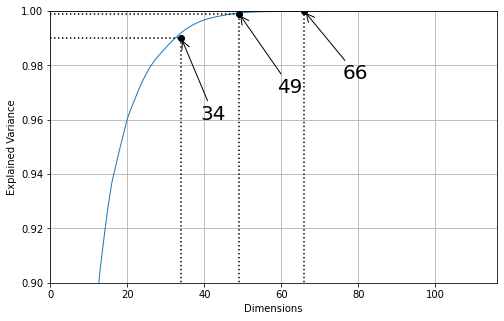

In [21]:
d = np.argmax(cumsum >= 0.9999) + 1
d1 = np.argmax(cumsum >= 0.999) + 1
d2 = np.argmax(cumsum >= 0.99) + 1
plt.figure(figsize=(8,5))
plt.plot(cumsum, linewidth=1)
plt.axis([0, d+50, 0, 1])
plt.xlabel("Dimensions")
plt.ylabel("Explained Variance")
plt.plot([d, d], [0, 0.9999], "k:")
plt.plot([0, d], [0.9999, 0.9999], "k:")
plt.plot(d, 0.9999, "ko")
plt.annotate(d, xy=(d, 0.9999), xytext=(d+10, 0.975),
             arrowprops=dict(arrowstyle="->"), fontsize=20)
plt.plot([d1, d1], [0, 0.999], "k:")
plt.plot([0, d1], [0.999, 0.999], "k:")
plt.plot(d1, 0.999, "ko")
plt.annotate(d1, xy=(d1, 0.999), xytext=(d1+10, 0.97),
             arrowprops=dict(arrowstyle="->"), fontsize=20)
plt.plot([d2, d2], [0, 0.99], "k:")
plt.plot([0, d2], [0.99, 0.99], "k:")
plt.plot(d2, 0.99, "ko")
plt.annotate(d2, xy=(d2, 0.99), xytext=(d2+5, 0.96),
             arrowprops=dict(arrowstyle="->"), fontsize=20)
plt.grid(True)
plt.ylim(0.9,1)
plt.show()

In [22]:
pca = PCA(n_components=0.999)
x_train_pca=pca.fit_transform(x_train)
x_val_pca=pca.transform(x_val)
x_test_pca=pca.transform(x_test)

In [23]:
print('Dimensions x_train_pca:',x_train_pca.shape)
print('Dimensions x_val_pca:',x_val_pca.shape)
print('Dimensions x_test_pca:',x_test_pca.shape)

Dimensions x_train_pca: (19205, 49)
Dimensions x_val_pca: (1197, 49)
Dimensions x_test_pca: (5925, 49)


### Dummy

              precision    recall  f1-score   support

       Alone      0.000     0.000     0.000       408
     Spontan      0.319     1.000     0.484       382
        Sync      0.000     0.000     0.000       407

    accuracy                          0.319      1197
   macro avg      0.106     0.333     0.161      1197
weighted avg      0.102     0.319     0.154      1197



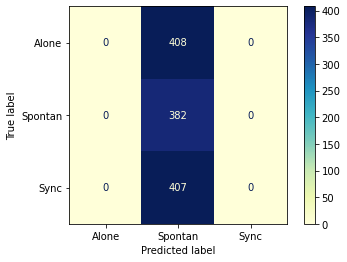

In [26]:
pipe_dum = Pipeline([
    ('scaler', StandardScaler()),
    ('dummy', DummyClassifier())
])
pipe_dum.fit(x_train_pca, y_train)
dumpred = pipe_dum.predict(x_val_pca)
accuracydum=accuracy_score(y_val, dumpred)
print(classification_report(y_val, dumpred,digits=3,target_names=class_names,zero_division =0))
plot_confusion_matrix(pipe_dum, x_val_pca, y_val,display_labels=class_names,cmap='YlGnBu')

### Random Forest

In [27]:
n_estimators = [int(x) for x in np.linspace(200, 2000, num = 19)]
max_features = ['auto', 'sqrt']
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
min_samples_split = [2, 5, 10]
min_samples_leaf = [1, 2, 4]
bootstrap = [True, False]
rf_grid = {'rf__n_estimators': n_estimators,
               'rf__max_features': max_features,
               'rf__max_depth': max_depth,
               'rf__min_samples_split': min_samples_split,
               'rf__min_samples_leaf': min_samples_leaf,
               'rf__bootstrap': bootstrap}

In [28]:
pipe_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier())
])
rf_tun = RandomizedSearchCV(estimator = pipe_rf, param_distributions= rf_grid, cv = 5,n_iter=20,n_jobs = -1)
rf_tun.fit(x_train_pca, y_train)

print('Best param of RandomSearch - RandomForest:',rf_tun.best_params_)
print('Best Score of RandomSearch - RandomForest:',rf_tun.best_score_)

Best param of RandomSearch - RandomForest: {'rf__n_estimators': 1500, 'rf__min_samples_split': 2, 'rf__min_samples_leaf': 1, 'rf__max_features': 'sqrt', 'rf__max_depth': None, 'rf__bootstrap': False}
Best Score of RandomSearch - RandomForest: 0.8567039833376725


              precision    recall  f1-score   support

       Alone      0.998     0.998     0.998       408
     Spontan      0.719     0.851     0.779       382
        Sync      0.831     0.688     0.753       407

    accuracy                          0.845      1197
   macro avg      0.849     0.845     0.843      1197
weighted avg      0.852     0.845     0.845      1197



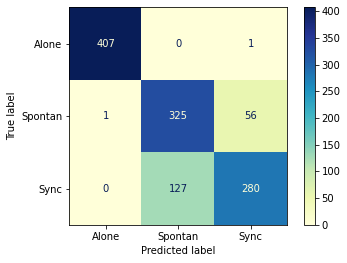

In [30]:
pipe_rf.set_params(**rf_tun.best_params_)
pipe_rf.fit(x_train_pca, y_train)
rfpred = pipe_rf.predict(x_val_pca)
accuracyrf=accuracy_score(y_val, rfpred)
print(classification_report(y_val, rfpred,digits=3,target_names=class_names))
from sklearn.metrics import plot_confusion_matrix
plot_confusion_matrix(pipe_rf, x_val_pca, y_val,display_labels=class_names,cmap='YlGnBu')

### KNN

Text(0, 0.5, 'Testing Accuracy')

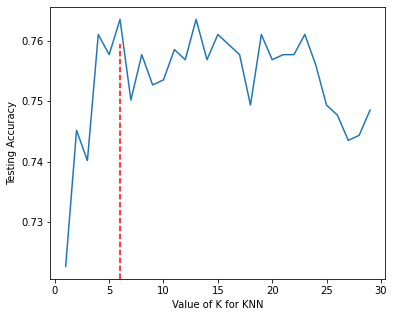

In [31]:
sc=[];k_range = list(range(1, 30))
for k in k_range:
    temppipe=Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=k))
    ])
    temppipe.fit(x_train_pca, y_train)
    sc.append(temppipe.score(x_val_pca,y_val))
m=sc.index(max(sc))+1
#plot graph showing percentage of accuracy by number of neighbors
f, ax = plt.subplots(figsize = (6,5))
ax.plot(k_range, sc)
ax.axvline(m, ls='--',ymax=max(sc)+0.1,c='r',solid_capstyle='round')
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

              precision    recall  f1-score   support

       Alone      0.946     0.897     0.921       408
     Spontan      0.637     0.717     0.675       382
        Sync      0.721     0.673     0.696       407

    accuracy                          0.764      1197
   macro avg      0.768     0.763     0.764      1197
weighted avg      0.771     0.764     0.766      1197



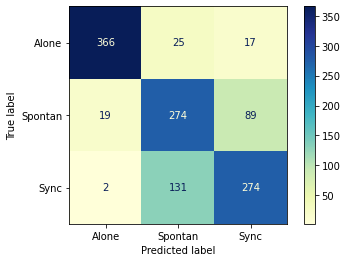

In [32]:
pipe_knn = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=m))
])
pipe_knn.fit(x_train_pca, y_train)
knnpred = pipe_knn.predict(x_val_pca)
accuracyknn=accuracy_score(y_val, knnpred)

print(classification_report(y_val, knnpred,digits=3,target_names=class_names))
plot_confusion_matrix(pipe_knn, x_val_pca, y_val,display_labels=class_names,cmap='YlGnBu')

### Logistic Regression

In [33]:
pipe_lr = Pipeline([
    ('scaler', StandardScaler()),
    ('lr', LogisticRegression(max_iter=2000))
])
lr_grid = {'lr__penalty' : ['l1', 'l2'],'lr__C' : np.logspace(-4, 4, 20),'lr__solver' : ['liblinear']}
lr_tun = RandomizedSearchCV(estimator = pipe_lr, param_distributions= lr_grid, cv = 5,n_iter=100, n_jobs = -1)
lr_tun.fit(x_train_pca, y_train)

print('Best param of RandomSearch - LogisticRegression:',lr_tun.best_params_)
print('Best Score of RandomSearch - LogisticRegression:',lr_tun.best_score_)

Best param of RandomSearch - LogisticRegression: {'lr__solver': 'liblinear', 'lr__penalty': 'l2', 'lr__C': 0.0006951927961775605}
Best Score of RandomSearch - LogisticRegression: 0.8252017703722988


              precision    recall  f1-score   support

       Alone      0.995     1.000     0.998       408
     Spontan      0.662     0.793     0.721       382
        Sync      0.763     0.617     0.682       407

    accuracy                          0.804      1197
   macro avg      0.807     0.803     0.800      1197
weighted avg      0.810     0.804     0.802      1197



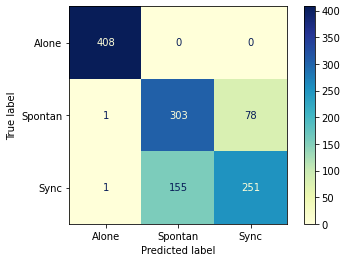

In [34]:
pipe_lr.set_params(**lr_tun.best_params_)
pipe_lr.fit(x_train_pca, y_train)
lrpred = pipe_lr.predict(x_val_pca)
accuracylr=accuracy_score(y_val, lrpred)
print(classification_report(y_val, lrpred,digits=3,target_names=class_names))
plot_confusion_matrix(pipe_lr, x_val_pca, y_val,display_labels=class_names,cmap='YlGnBu')

### Extra Trees

In [35]:
et_grid = {'et__n_estimators': n_estimators,
               'et__max_features': max_features,
               'et__max_depth': max_depth,
               'et__min_samples_split': min_samples_split,
               'et__min_samples_leaf': min_samples_leaf,
               'et__bootstrap': bootstrap}
pipe_et = Pipeline([
    ('scaler', StandardScaler()),
    ('et', ExtraTreesClassifier())
])
et_tun = RandomizedSearchCV(estimator = pipe_et, param_distributions = et_grid, cv = 5, n_iter=20,n_jobs=-1)
et_tun.fit(x_train_pca, y_train)

print('Best param of RandomSearch - ExtraTrees:',et_tun.best_params_)
print('Best Score of RandomSearch - ExtraTrees:',et_tun.best_score_)

Best param of RandomSearch - ExtraTrees: {'et__n_estimators': 1200, 'et__min_samples_split': 2, 'et__min_samples_leaf': 2, 'et__max_features': 'auto', 'et__max_depth': 40, 'et__bootstrap': False}
Best Score of RandomSearch - ExtraTrees: 0.8679510544129133


              precision    recall  f1-score   support

       Alone      0.995     1.000     0.998       408
     Spontan      0.704     0.908     0.793       382
        Sync      0.888     0.641     0.745       407

    accuracy                          0.849      1197
   macro avg      0.862     0.850     0.845      1197
weighted avg      0.866     0.849     0.846      1197



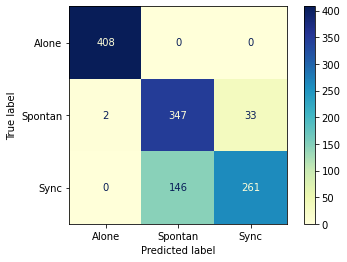

In [36]:
pipe_et.set_params(**et_tun.best_params_)
pipe_et.fit(x_train_pca, y_train)
etpred = pipe_et.predict(x_val_pca)
accuracyet=accuracy_score(y_val, etpred)
print(classification_report(y_val, etpred,digits=3,target_names=class_names))
plot_confusion_matrix(pipe_et, x_val_pca, y_val,display_labels=class_names,cmap='YlGnBu')

### XGBoost

In [37]:
maxd = [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None]
n_est= [200, 400, 600, 800, 1000, 1200, 1400,1600, 1800,2000]
lr= [0.1, 0.01,0.2,0.3, 0.05]
subsample= [0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colsample_bytree= [0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
colsample_bylevel=[0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
min_child_weight=[0.5, 1.0, 3.0, 5.0, 7.0, 10.0]
gamma=[0, 0.25, 0.5, 1.0]
reg_lambda= [0.1, 1.0, 5.0, 10.0, 50.0, 100.0]
xgb_grid = dict(xgb__n_estimators=n_est,xgb__learning_rate=lr,xgb__colsample_bytree=colsample_bytree,
                  xgb__subsample=subsample,
                  xgb__colsample_bylevel=colsample_bylevel,
                  xgb__min_child_weight=min_child_weight,
                  xgb__reg_lambda=reg_lambda,
                  xgb__gamma=gamma,
                  xgb__max_depth=maxd)
pipe_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb',XGBClassifier(n_estimators=500,use_label_encoder=False,eval_metric='mlogloss'))
])
xgb_tun = RandomizedSearchCV(estimator = pipe_xgb, param_distributions = xgb_grid, cv = 5,n_jobs=-1)
xgb_tun.fit(x_train_pca, y_train)

print('Best param of RandomSearch - XGBoost:',xgb_tun.best_params_)
print('Best Score of RandomSearch - XGBoost:',xgb_tun.best_score_)

Best param of RandomSearch - XGBoost: {'xgb__subsample': 0.5, 'xgb__reg_lambda': 5.0, 'xgb__n_estimators': 1400, 'xgb__min_child_weight': 1.0, 'xgb__max_depth': 40, 'xgb__learning_rate': 0.05, 'xgb__gamma': 0.5, 'xgb__colsample_bytree': 0.7, 'xgb__colsample_bylevel': 0.8}
Best Score of RandomSearch - XGBoost: 0.8647747982296277


              precision    recall  f1-score   support

       Alone      0.998     1.000     0.999       408
     Spontan      0.758     0.785     0.771       382
        Sync      0.793     0.764     0.778       407

    accuracy                          0.851      1197
   macro avg      0.849     0.850     0.849      1197
weighted avg      0.852     0.851     0.851      1197



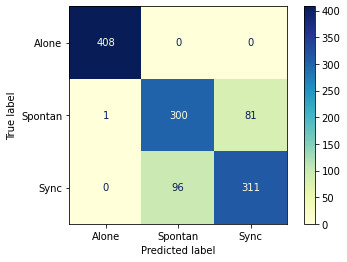

In [38]:
pipe_xgb.set_params(**xgb_tun.best_params_)
pipe_xgb.fit(x_train_pca, y_train)
xgbpred = pipe_xgb.predict(x_val_pca)
accuracyxgb=accuracy_score(y_val, xgbpred)
print(classification_report(y_val, xgbpred,digits=3,target_names=class_names))
plot_confusion_matrix(pipe_xgb, x_val_pca, y_val,display_labels=class_names,cmap='YlGnBu')

### Bagging

              precision    recall  f1-score   support

       Alone      0.995     1.000     0.998       408
     Spontan      0.663     0.793     0.722       382
        Sync      0.764     0.619     0.684       407

    accuracy                          0.805      1197
   macro avg      0.807     0.804     0.801      1197
weighted avg      0.810     0.805     0.803      1197



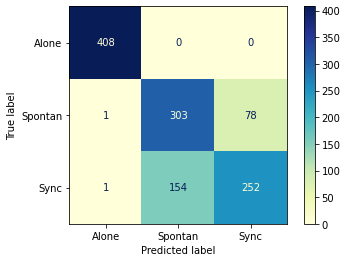

In [39]:
d=lr_tun.best_params_
d1 = { k.replace('lr__', ''): v for k,v in d.items() }

pipe_bag = Pipeline([('scaler', StandardScaler()),
        ('bag', BaggingClassifier(base_estimator=LogisticRegression(**d1),n_estimators=10, random_state=0))])
pipe_bag.fit(x_train_pca, y_train)
bagpred = pipe_bag.predict(x_val_pca)
accuracybag=accuracy_score(y_val, bagpred)
print(classification_report(y_val, bagpred,digits=3,target_names=class_names))
plot_confusion_matrix(pipe_bag, x_val_pca, y_val,display_labels=class_names,cmap='YlGnBu')

### AdaBoost

              precision    recall  f1-score   support

       Alone      0.988     0.993     0.990       408
     Spontan      0.649     0.576     0.610       382
        Sync      0.638     0.703     0.669       407

    accuracy                          0.761      1197
   macro avg      0.758     0.757     0.756      1197
weighted avg      0.761     0.761     0.760      1197



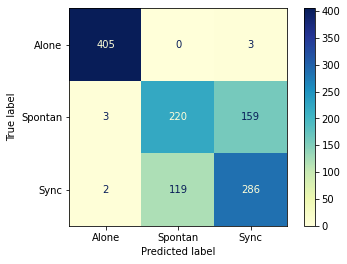

In [40]:
pipe_adb = Pipeline([
    ('scaler', StandardScaler()),
    ('adb',AdaBoostClassifier(DecisionTreeClassifier(max_depth=80),n_estimators = 1000, random_state = 0, learning_rate = 0.5))
])
pipe_adb.fit(x_train_pca, y_train)
adbpred = pipe_adb.predict(x_val_pca)
accuracyadb=accuracy_score(y_val, adbpred)
print(classification_report(y_val, adbpred,digits=3,target_names=class_names))
plot_confusion_matrix(pipe_adb, x_val_pca, y_val,display_labels=class_names,cmap='YlGnBu')

### Voting

              precision    recall  f1-score   support

       Alone      0.998     1.000     0.999       408
     Spontan      0.738     0.825     0.779       382
        Sync      0.817     0.725     0.768       407

    accuracy                          0.850      1197
   macro avg      0.851     0.850     0.849      1197
weighted avg      0.853     0.850     0.850      1197



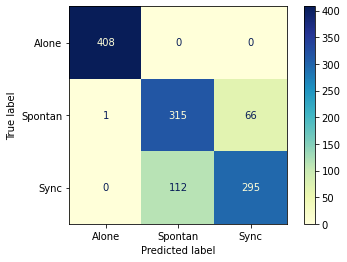

In [42]:
d=rf_tun.best_params_
d2 = { k.replace('rf__', ''): v for k,v in d.items() }
d=xgb_tun.best_params_
d3 = { k.replace('xgb__', ''): v for k,v in d.items() }
d=et_tun.best_params_
d4 = { k.replace('et__', ''): v for k,v in d.items() }
pipe_vote = Pipeline([('scaler', StandardScaler()),
        ('voting_clf', VotingClassifier(estimators=[('xgb',XGBClassifier(**d3,eval_metric='mlogloss')),
        ('lr', LogisticRegression(**d1)),('knn', KNeighborsClassifier(n_neighbors=m)),
        ('rf', RandomForestClassifier(**d2)),
        ('et', ExtraTreesClassifier(**d4))], voting='soft'))])
pipe_vote.fit(x_train_pca, y_train)
votepred = pipe_vote.predict(x_val_pca)
accuracyvt=accuracy_score(y_val, votepred)
print(classification_report(y_val, votepred,digits=3,target_names=class_names))
plot_confusion_matrix(pipe_vote, x_val_pca, y_val,display_labels=class_names,cmap='YlGnBu')

### Stacking

              precision    recall  f1-score   support

       Alone      0.998     1.000     0.999       408
     Spontan      0.719     0.872     0.788       382
        Sync      0.852     0.681     0.757       407

    accuracy                          0.850      1197
   macro avg      0.856     0.851     0.848      1197
weighted avg      0.859     0.850     0.849      1197



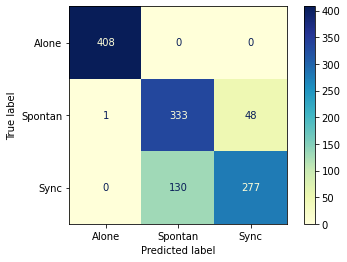

In [43]:
pipe_st = Pipeline([('scaler', StandardScaler()),
        ('st',StackingClassifier(estimators=
        [('xgb',XGBClassifier(**d3,eval_metric='mlogloss')),
        ('lr', LogisticRegression(**d1)),
        ('rf', RandomForestClassifier(**d2)),
        ('et', ExtraTreesClassifier(**d4))],final_estimator=LogisticRegression(solver='lbfgs', max_iter=1000)))])
pipe_st.fit(x_train_pca, y_train)
stpred= pipe_st.predict(x_val_pca)
accuracyst=accuracy_score(y_val, stpred)

print(classification_report(y_val, stpred,digits=3,target_names=class_names))
plot_confusion_matrix(pipe_st, x_val_pca, y_val,display_labels=class_names,cmap='YlGnBu')

### Summary

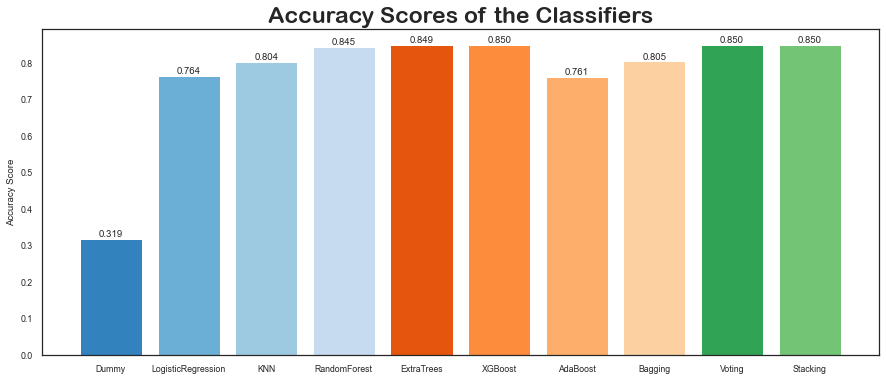

In [49]:

accArr = [accuracydum, accuracyknn, accuracylr, accuracyrf, accuracyet, accuracyxgb, accuracyadb, accuracybag,
          accuracyvt, accuracyst]
sns.set_style("white")
fig = plt.figure(figsize=(15,6))
labels = ['Dummy','LogisticRegression','KNN', 'RandomForest','ExtraTrees','XGBoost','AdaBoost','Bagging', 'Voting','Stacking']
my_cmap = plt.get_cmap("tab20c")
rescale = lambda y: (y - np.min(y)) / (np.max(y) - np.min(y))
ax=plt.bar(labels, accArr,color=my_cmap.colors)
plt.ylabel("Accuracy Score")
plt.title("Accuracy Scores of the Classifiers",fontsize = 23, fontweight='bold',fontfamily='Arial Rounded MT Bold')
plt.bar_label(ax,fmt='%1.3f')


sns.set(font_scale=0.8)
plt.show()

## Final Model - Voting

We got some models with similar acuuracy on validation. Selected for the final model the Voting.

              precision    recall  f1-score   support

       Alone      0.997     0.999     0.998      1900
     Spontan      0.781     0.936     0.851      2034
        Sync      0.918     0.731     0.814      1991

    accuracy                          0.887      5925
   macro avg      0.899     0.889     0.888      5925
weighted avg      0.896     0.887     0.886      5925



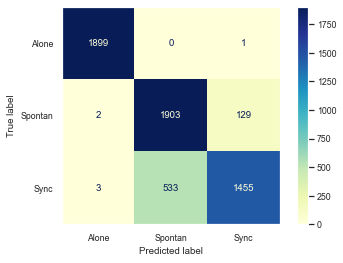

In [50]:
finalpred=pipe_vote.predict(x_test_pca)
print(classification_report(y_test, finalpred,digits=3,target_names=class_names))
plot_confusion_matrix(pipe_vote, x_test_pca, y_test,display_labels=class_names,cmap='YlGnBu')
plt.grid(False)
plt.show()

#### Final accuracy is 0.887% - Voting (XGB, Logistic Regression, KNN, Random Forest, Extra Trees)